<a href="https://colab.research.google.com/github/ledio05/MA-Thesis_IMU-Gait-Predictor/blob/master/Fall_Detection_MA_Thesis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div class="markdown-google-sans">

## Machine learning
</div>

With Colab you can import an image dataset, train an image classifier on it, and evaluate the model, all in just [a few lines of code](https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/quickstart/beginner.ipynb).

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis
from sklearn.preprocessing import StandardScaler

# Configuration
WINDOW_SIZE = 30
STRIDE = 15
FALL_TIMES = {
    "Hoja1": 4305, "Hoja2": 4305, "Hoja3": 2800, "Hoja4": 3745,
    "Hoja5": 2555, "Hoja6": 3710, "Hoja7": 2135, "Hoja8": 1575,
    "Hoja9": 1470, "Hoja10": 2310, "Hoja11": 2100, "Hoja12": 1505,
    "Hoja13": 1820, "Hoja14": 1610, "Hoja15": 1785
}  # in milliseconds

# Load and clean all sheets
all_sheets = pd.read_excel("falls1.xls", sheet_name=None)
cleaned_sheets = {}
cleaned_sheets_final = {}

for sheet_name, df in all_sheets.items():
    # Clean column names
    df.columns = [str(col).strip().lower().replace(' ', '_').replace('(', '').replace(')', '') for col in df.columns]

    # Rename timems to time_ms if needed
    if 'timems' in df.columns:
        df = df.rename(columns={'timems': 'time_ms'})

    df['source_sheet'] = sheet_name
    cleaned_sheets[sheet_name] = df

print(f"✅ Loaded and cleaned {len(cleaned_sheets)} sheets.")

# Preprocess each sheet
sensor_cols = ['pitch', 'roll', 'yaw', 'gyrox', 'gyroy', 'gyroz']

for name, df in cleaned_sheets.items():
    # Validate required columns
    if not all(col in df.columns for col in sensor_cols + ['time_ms']):
        print(f"⚠️ Skipping {name} — missing required columns")
        continue

    # Process data
    df = df.interpolate(method='linear', limit_direction='both').dropna()

    # Only standardize if there's variation
    if len(df) > 1:
        df[sensor_cols] = StandardScaler().fit_transform(df[sensor_cols])
    else:
        print(f"⚠️ Skipping standardization for {name} - insufficient data")

    cleaned_sheets_final[name] = df

print(f"✅ Preprocessed {len(cleaned_sheets_final)} sheets.")

# Enhanced feature extraction
def extract_features(window_df):
    features = {}
    for col in sensor_cols:
        signal = window_df[col].values

        # Basic stats
        features[f'{col}_mean'] = np.mean(signal)
        features[f'{col}_std'] = np.std(signal)
        features[f'{col}_min'] = np.min(signal)
        features[f'{col}_max'] = np.max(signal)
        features[f'{col}_range'] = features[f'{col}_max'] - features[f'{col}_min']

        # Advanced stats
        features[f'{col}_median'] = np.median(signal)
        features[f'{col}_skew'] = skew(signal)
        features[f'{col}_kurtosis'] = kurtosis(signal)
        features[f'{col}_rms'] = np.sqrt(np.mean(signal**2))

        # Percentiles
        features[f'{col}_q1'] = np.percentile(signal, 25)
        features[f'{col}_q3'] = np.percentile(signal, 75)
        features[f'{col}_iqr'] = features[f'{col}_q3'] - features[f'{col}_q1']

        # Zero-crossing rate
        zero_crossings = np.where(np.diff(np.sign(signal)))[0]
        features[f'{col}_zcr'] = len(zero_crossings) / len(signal)

    return features

# Create windowed features with improved labeling
feature_rows = []

for name, df in cleaned_sheets_final.items():
    if name not in FALL_TIMES:
        print(f"⚠️ Skipping {name} — no fall time specified")
        continue

    fall_time = FALL_TIMES[name]
    num_windows = (len(df) - WINDOW_SIZE) // STRIDE + 1

    for i in range(num_windows):
        start_idx = i * STRIDE
        end_idx = start_idx + WINDOW_SIZE
        window = df.iloc[start_idx:end_idx]

        # Get window timestamps
        window_start = window['time_ms'].iloc[0]
        window_end = window['time_ms'].iloc[-1]

        # IMPROVED LABELING LOGIC
        if window_end < fall_time:
            # Entirely before fall
            label = 0  # Pre-fall (normal)
        elif window_start > fall_time:
            # Entirely after fall
            label = 2  # Post-fall
        else:
            # Window contains fall moment
            label = 1  # Fall impact

        # Extract features
        feats = extract_features(window)
        feats['source'] = name
        feats['window_id'] = i
        feats['start_time'] = window_start
        feats['end_time'] = window_end
        feats['label'] = label
        feats['fall_time'] = fall_time

        feature_rows.append(feats)

# Create final DataFrame
feature_df = pd.DataFrame(feature_rows)

# Analyze label distribution
label_counts = feature_df['label'].value_counts()
print("\nLabel Distribution:")
print(f"Normal (0): {label_counts.get(0, 0)} windows")
print(f"Fall Impact (1): {label_counts.get(1, 0)} windows")
print(f"Post-Fall (2): {label_counts.get(2, 0)} windows")

# Save results
feature_df.to_excel("labeled_gait_features.xlsx", index=False)
print("\n✅ Saved labeled features to 'labeled_gait_features.xlsx'")

# Optional: Add validation plots
import matplotlib.pyplot as plt

def plot_label_distribution(source_name):
    """Plot timeline with labels for visual validation"""
    sheet_df = feature_df[feature_df['source'] == source_name]
    fall_time = FALL_TIMES[source_name]

    plt.figure(figsize=(15, 6))

    # Plot acceleration with coloring based on label
    colors = {0: 'green', 1: 'red', 2: 'orange'}
    for label, group in sheet_df.groupby('label'):
        plt.scatter(
            (group['start_time'] + group['end_time'])/2,
            group['gyrox_mean'],
            color=colors[label],
            label=f'Label {label}',
            alpha=0.7
        )

    # Add fall time marker
    plt.axvline(x=fall_time, color='black', linestyle='--', label='Fall Moment')

    plt.title(f"Label Distribution - {source_name}")
    plt.xlabel("Time (ms)")
    plt.ylabel("Normalized Gyro X")
    plt.legend()
    plt.savefig(f"label_validation_{source_name}.png", bbox_inches='tight')
    plt.close()

# Generate validation plots for each sheet
for sheet in FALL_TIMES.keys():
    if sheet in cleaned_sheets_final:
        plot_label_distribution(sheet)
        print(f"Generated validation plot for {sheet}")

✅ Loaded and cleaned 16 sheets.
⚠️ Skipping graphs — missing required columns
✅ Preprocessed 15 sheets.


/tmp/ipython-input-2-844883444.py:44: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df = df.interpolate(method='linear', limit_direction='both').dropna()
/tmp/ipython-input-2-844883444.py:44: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df = df.interpolate(method='linear', limit_direction='both').dropna()
/tmp/ipython-input-2-844883444.py:44: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df = df.interpolate(method='linear', limit_direction='both').dropna()
/tmp/ipython-input-2-844883444.py:44: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_ob


Label Distribution:
Normal (0): 50 windows
Fall Impact (1): 22 windows
Post-Fall (2): 6 windows

✅ Saved labeled features to 'labeled_gait_features.xlsx'
Generated validation plot for Hoja1
Generated validation plot for Hoja2
Generated validation plot for Hoja3
Generated validation plot for Hoja4
Generated validation plot for Hoja5
Generated validation plot for Hoja6
Generated validation plot for Hoja7
Generated validation plot for Hoja8
Generated validation plot for Hoja9
Generated validation plot for Hoja10
Generated validation plot for Hoja11
Generated validation plot for Hoja12
Generated validation plot for Hoja13
Generated validation plot for Hoja14
Generated validation plot for Hoja15


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import StandardScaler
from collections import Counter
# Load your preprocessed and labeled feature set
feature_df = pd.read_excel("labeled_gait_features.xlsx")
# Label = 1 → fall impact, 0 and 2 → non-fall
feature_df['target'] = np.where(feature_df['label'] == 1, 1, 0)
# Drop unused or metadata columns
X = feature_df.drop(columns=['target', 'label', 'source', 'window_id', 'start_time', 'end_time', 'fall_time'])
y = feature_df['target'].values
groups = feature_df['source'].values
gss = GroupShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
train_idx, test_idx = next(gss.split(X, y, groups=groups))

X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y[train_idx], y[test_idx]
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
def generate_synthetic_falls(X_train, y_train, multiplier=3, noise_std=0.02):
    fall_mask = y_train == 1
    X_falls = X_train[fall_mask]
    y_falls = y_train[fall_mask]

    synthetic_X = []
    synthetic_y = []

    for _ in range(multiplier):
        noisy = X_falls + np.random.normal(0, noise_std, X_falls.shape)
        synthetic_X.append(noisy)
        synthetic_y.append(np.ones(len(y_falls)))

    X_aug = np.vstack([X_train] + synthetic_X)
    y_aug = np.concatenate([y_train] + synthetic_y)
    return X_aug, y_aug

# Apply augmentation
X_train_aug, y_train_aug = generate_synthetic_falls(X_train_scaled, y_train)

print("Original training class distribution:", Counter(y_train))
print("Augmented training class distribution:", Counter(y_train_aug))


Original training class distribution: Counter({np.int64(0): 32, np.int64(1): 15})
Augmented training class distribution: Counter({np.float64(1.0): 60, np.float64(0.0): 32})


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, RocCurveDisplay
import matplotlib.pyplot as plt

# Initialize models with class_weight to handle imbalance
models = {
    "Random Forest": RandomForestClassifier(class_weight='balanced', random_state=42),
    "Logistic Regression": LogisticRegression(class_weight='balanced', solver='liblinear', max_iter=1000, random_state=42),
    "SVM": SVC(class_weight='balanced', probability=True, random_state=42)
}

# Store evaluation results
results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train_aug, y_train_aug)

    y_pred = model.predict(X_test_scaled)
    y_proba = model.predict_proba(X_test_scaled)[:, 1]

    results[name] = {
        'model': model,
        'y_pred': y_pred,
        'y_proba': y_proba,
        'report': classification_report(y_test, y_pred, digits=4),
        'conf_matrix': confusion_matrix(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_proba)
    }

    print(f"\n{name} Classification Report:")
    print(results[name]['report'])
    print("Confusion Matrix:")
    print(results[name]['conf_matrix'])
    print(f"ROC AUC: {results[name]['roc_auc']:.4f}")



Training Random Forest...

Random Forest Classification Report:
              precision    recall  f1-score   support

           0     0.9583    0.9583    0.9583        24
           1     0.8571    0.8571    0.8571         7

    accuracy                         0.9355        31
   macro avg     0.9077    0.9077    0.9077        31
weighted avg     0.9355    0.9355    0.9355        31

Confusion Matrix:
[[23  1]
 [ 1  6]]
ROC AUC: 0.9881

Training Logistic Regression...

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0     0.9583    0.9583    0.9583        24
           1     0.8571    0.8571    0.8571         7

    accuracy                         0.9355        31
   macro avg     0.9077    0.9077    0.9077        31
weighted avg     0.9355    0.9355    0.9355        31

Confusion Matrix:
[[23  1]
 [ 1  6]]
ROC AUC: 0.9821

Training SVM...

SVM Classification Report:
              precision    recall  f1-score   support

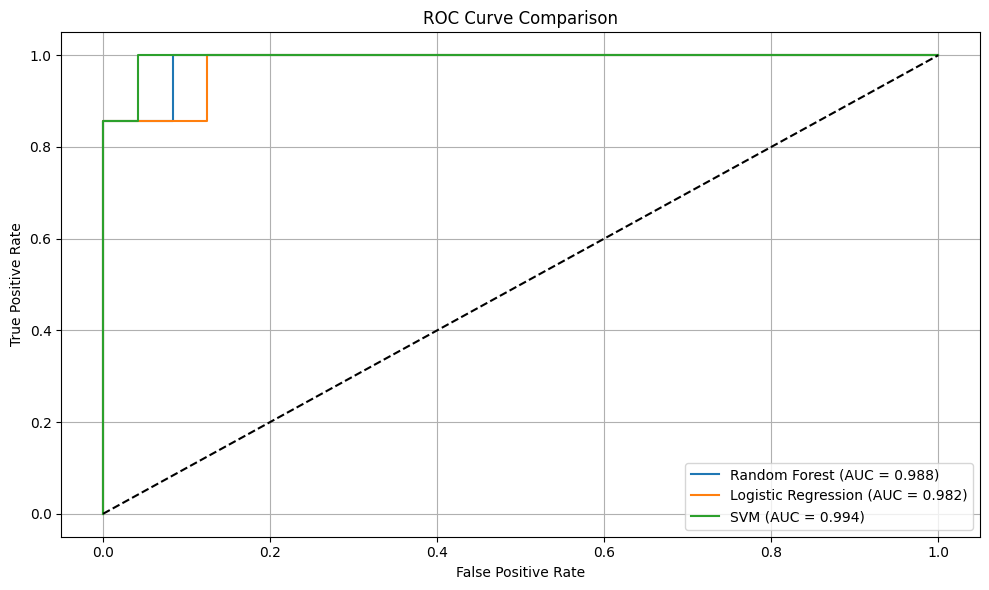

In [ ]:
plt.figure(figsize=(10, 6))

for name, res in results.items():
    fpr, tpr, _ = roc_curve(y_test, res['y_proba'])
    plt.plot(fpr, tpr, label=f'{name} (AUC = {res["roc_auc"]:.3f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis
from sklearn.preprocessing import StandardScaler
from sklearn.svm import OneClassSVM
import matplotlib.pyplot as plt

# Configuration
WINDOW_SIZE = 30
STRIDE = 15
FALL_TIMES = {
    "Hoja1": 4305, "Hoja2": 4305, "Hoja3": 2800, "Hoja4": 3745,
    "Hoja5": 2555, "Hoja6": 3710, "Hoja7": 2135, "Hoja8": 1575,
    "Hoja9": 1470, "Hoja10": 2310, "Hoja11": 2100, "Hoja12": 1505,
    "Hoja13": 1820, "Hoja14": 1610, "Hoja15": 1785
}

# Load and clean all sheets
all_sheets = pd.read_excel("falls1.xls", sheet_name=None)
cleaned_sheets = {}
cleaned_sheets_final = {}

for sheet_name, df in all_sheets.items():
    df.columns = [str(col).strip().lower().replace(' ', '_').replace('(', '').replace(')', '') for col in df.columns]
    if 'timems' in df.columns:
        df = df.rename(columns={'timems': 'time_ms'})
    df['source_sheet'] = sheet_name
    cleaned_sheets[sheet_name] = df

print(f"✅ Loaded and cleaned {len(cleaned_sheets)} sheets.")

# Preprocessing
sensor_cols = ['pitch', 'roll', 'yaw', 'gyrox', 'gyroy', 'gyroz']

for name, df in cleaned_sheets.items():
    if not all(col in df.columns for col in sensor_cols + ['time_ms']):
        print(f"⚠️ Skipping {name} — missing required columns")
        continue
    df = df.interpolate(method='linear', limit_direction='both').dropna()
    if len(df) > 1:
        df[sensor_cols] = StandardScaler().fit_transform(df[sensor_cols])
    else:
        print(f"⚠️ Skipping standardization for {name} - insufficient data")
    cleaned_sheets_final[name] = df

print(f"✅ Preprocessed {len(cleaned_sheets_final)} sheets.")

# Feature Extraction
def extract_features(window_df):
    features = {}
    for col in sensor_cols:
        signal = window_df[col].values
        features[f'{col}_mean'] = np.mean(signal)
        features[f'{col}_std'] = np.std(signal)
        features[f'{col}_min'] = np.min(signal)
        features[f'{col}_max'] = np.max(signal)
        features[f'{col}_range'] = features[f'{col}_max'] - features[f'{col}_min']
        features[f'{col}_median'] = np.median(signal)
        features[f'{col}_skew'] = skew(signal)
        features[f'{col}_kurtosis'] = kurtosis(signal)
        features[f'{col}_rms'] = np.sqrt(np.mean(signal**2))
        features[f'{col}_q1'] = np.percentile(signal, 25)
        features[f'{col}_q3'] = np.percentile(signal, 75)
        features[f'{col}_iqr'] = features[f'{col}_q3'] - features[f'{col}_q1']
        zero_crossings = np.where(np.diff(np.sign(signal)))[0]
        features[f'{col}_zcr'] = len(zero_crossings) / len(signal)
    return features

# Create windowed features (no labels)
feature_rows = []

for name, df in cleaned_sheets_final.items():
    if name not in FALL_TIMES:
        print(f"⚠️ Skipping {name} — no fall time specified")
        continue

    fall_time = FALL_TIMES[name]
    num_windows = (len(df) - WINDOW_SIZE) // STRIDE + 1

    for i in range(num_windows):
        start_idx = i * STRIDE
        end_idx = start_idx + WINDOW_SIZE
        window = df.iloc[start_idx:end_idx]
        window_start = window['time_ms'].iloc[0]
        window_end = window['time_ms'].iloc[-1]

        feats = extract_features(window)
        feats['source'] = name
        feats['window_id'] = i
        feats['start_time'] = window_start
        feats['end_time'] = window_end
        feats['fall_time'] = fall_time
        feature_rows.append(feats)

feature_df = pd.DataFrame(feature_rows)

# ✅ Train on pre-fall windows only (normal gait)
train_df = feature_df[feature_df['end_time'] < feature_df['fall_time']]
X_train = train_df.drop(columns=['source', 'window_id', 'start_time', 'end_time', 'fall_time'])

print(f"\nTraining on {len(X_train)} normal windows...")

# Train One-Class SVM
model = OneClassSVM(kernel='rbf', gamma='auto', nu=0.02)
model.fit(X_train)

# Predict anomalies
X_all = feature_df.drop(columns=['source', 'window_id', 'start_time', 'end_time', 'fall_time'])
feature_df['anomaly'] = model.predict(X_all)  # -1 = anomaly, 1 = normal

# Save results
feature_df.to_excel("anomaly_detection_features.xlsx", index=False)
print("✅ Saved anomaly detection results to 'anomaly_detection_features.xlsx'")

# Plotting
def plot_anomalies(source_name):
    df = feature_df[feature_df['source'] == source_name]
    fall_time = FALL_TIMES[source_name]

    plt.figure(figsize=(15, 6))
    colors = {-1: 'red', 1: 'green'}
    for label, group in df.groupby('anomaly'):
        plt.scatter(
            (group['start_time'] + group['end_time']) / 2,
            group['gyrox_mean'],
            color=colors[label],
            label='Anomaly' if label == -1 else 'Normal',
            alpha=0.7
        )

    plt.axvline(x=fall_time, color='black', linestyle='--', label='Fall Moment')
    plt.title(f"Anomaly Detection - {source_name}")
    plt.xlabel("Time (ms)")
    plt.ylabel("Normalized Gyro X")
    plt.legend()
    plt.savefig(f"anomaly_plot_{source_name}.png", bbox_inches='tight')
    plt.close()

# Generate plots
for sheet in FALL_TIMES:
    if sheet in cleaned_sheets_final:
        plot_anomalies(sheet)
        print(f"📊 Generated anomaly plot for {sheet}")


✅ Loaded and cleaned 16 sheets.
⚠️ Skipping graphs — missing required columns
✅ Preprocessed 15 sheets.


/tmp/ipython-input-4-2932677236.py:39: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df = df.interpolate(method='linear', limit_direction='both').dropna()
/tmp/ipython-input-4-2932677236.py:39: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df = df.interpolate(method='linear', limit_direction='both').dropna()
/tmp/ipython-input-4-2932677236.py:39: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df = df.interpolate(method='linear', limit_direction='both').dropna()
/tmp/ipython-input-4-2932677236.py:39: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infe


Training on 50 normal windows...
✅ Saved anomaly detection results to 'anomaly_detection_features.xlsx'
📊 Generated anomaly plot for Hoja1
📊 Generated anomaly plot for Hoja2
📊 Generated anomaly plot for Hoja3
📊 Generated anomaly plot for Hoja4
📊 Generated anomaly plot for Hoja5
📊 Generated anomaly plot for Hoja6
📊 Generated anomaly plot for Hoja7
📊 Generated anomaly plot for Hoja8
📊 Generated anomaly plot for Hoja9
📊 Generated anomaly plot for Hoja10
📊 Generated anomaly plot for Hoja11
📊 Generated anomaly plot for Hoja12
📊 Generated anomaly plot for Hoja13
📊 Generated anomaly plot for Hoja14
📊 Generated anomaly plot for Hoja15


In [ ]:
def assign_true_label(row):
    if row['end_time'] < row['fall_time']:
        return 0  # normal
    else:
        return 1  # abnormal (fall or post-fall)

# Create evaluation ground truth
feature_df['true_label'] = feature_df.apply(assign_true_label, axis=1)
from sklearn.metrics import classification_report, confusion_matrix

# Convert model output: 1 → 0 (normal), -1 → 1 (anomaly)
feature_df['predicted_label'] = feature_df['anomaly'].apply(lambda x: 0 if x == 1 else 1)

# Generate confusion matrix
cm = confusion_matrix(feature_df['true_label'], feature_df['predicted_label'])
report = classification_report(feature_df['true_label'], feature_df['predicted_label'], target_names=["Normal", "Anomaly"])

print("Confusion Matrix:")
print(cm)
print("\nClassification Report:")
print(report)


Confusion Matrix:
[[43  7]
 [ 0 28]]

Classification Report:
              precision    recall  f1-score   support

      Normal       1.00      0.86      0.92        50
     Anomaly       0.80      1.00      0.89        28

    accuracy                           0.91        78
   macro avg       0.90      0.93      0.91        78
weighted avg       0.93      0.91      0.91        78



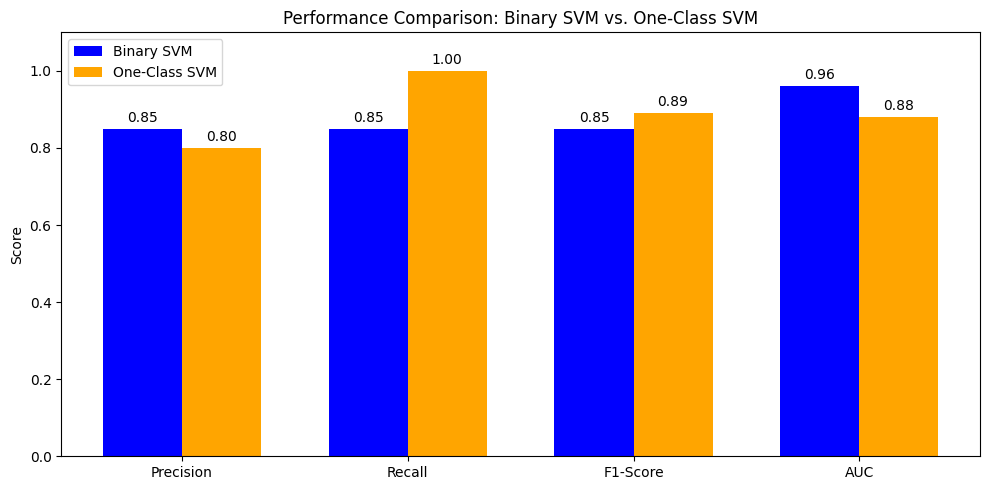

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

metrics = ['Precision', 'Recall', 'F1-Score', 'AUC']
binary_svm = [0.85, 0.85, 0.85, 0.96]
oneclass_svm = [0.80, 1.00, 0.89, 0.88]

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 5))
bars1 = ax.bar(x - width/2, binary_svm, width, label='Binary SVM', color='blue')
bars2 = ax.bar(x + width/2, oneclass_svm, width, label='One-Class SVM', color='orange')

ax.set_ylabel('Score')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
ax.set_ylim(0, 1.1)

# Add value labels
for bar in bars1 + bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom')

plt.title("Performance Comparison: Binary SVM vs. One-Class SVM")
plt.tight_layout()
plt.show()